In [1]:
# Basic imports

import pandas as pd
import torch

from torch.utils.data import DataLoader
from torch import nn, optim

# Import functions from src

from src.data_loader import (load_json_to_df, multi_hot_encode_row, stratified_train_test_val, CustomMultiLabelDataset,
                             tensor_checker)
from src.transforms import transform_basic
from src.models import get_resnet18_model
from src.train import train_model
from src.utils import plot_train_val_losses

device = "mps" if torch.backends.mps.is_available() else "cpu"

/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/annahan/miniforge3/envs/pytorch-1/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this

# 1) Prepare Data for Modeling

In [2]:
# Load data
df = load_json_to_df('0_main_dataset/data/df_5labels.json')

# Multi-hot-encode labels
df = multi_hot_encode_row(df)

# Stratified train-test-val split
train_df, test_df, val_df = stratified_train_test_val(df['image_path'],
                                                      df['mhe'],
                                                      train_testval_size=0.3,
                                                      test_val_size=0.5,
                                                      print_shapes=False)

# Define the transform

transform = transform_basic()

# Create the datasets

train_ds = CustomMultiLabelDataset(train_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)
test_ds = CustomMultiLabelDataset(test_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)
val_ds = CustomMultiLabelDataset(val_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)

# Create data loaders

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# Check the tensors

tensor_checker(train_loader, test_loader, val_loader)

<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])


In [3]:
# Define the number of classes

num_classes = len(df['mhe'][0])

# 2) Modeling

In [4]:
######### MODEL 1: Class Balance ##########

# Use BCEWithLogitsLoss's pos_weights to balance class weights

# step 1: calculate the weights
label_counts = train_df['mhe'].sum(axis=0)
print(f'label_counts: {label_counts}')

total_samples = train_df['mhe'].shape[0]
print(f'total_samples: {total_samples}')

pos_weights = total_samples / label_counts
print(f'pos_weights: {pos_weights}')

pos_weights = torch.tensor(pos_weights, dtype=torch.float32)
pos_weights = pos_weights.to(device)

label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]


In [5]:
# Define the model

model = get_resnet18_model(num_classes)

# Define loss and optimizer

criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model

num_epochs = 20

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model,
                                                                         train_loader,
                                                                         val_loader,
                                                                         criterion,
                                                                         optimizer,
                                                                         device,
                                                                         num_epochs=num_epochs)

Epoch 1/20 | Train Loss: 1.7694, Train Acc: 85.79% | Val Loss: 4.6899, Val Acc: 72.70%
Epoch 2/20 | Train Loss: 0.7489, Train Acc: 93.68% | Val Loss: 0.6372, Val Acc: 92.70%
Epoch 3/20 | Train Loss: 0.4799, Train Acc: 95.84% | Val Loss: 0.8182, Val Acc: 91.27%
Epoch 4/20 | Train Loss: 0.4430, Train Acc: 96.34% | Val Loss: 0.6313, Val Acc: 93.65%
Epoch 5/20 | Train Loss: 0.3424, Train Acc: 96.77% | Val Loss: 0.9379, Val Acc: 89.52%
Epoch 6/20 | Train Loss: 0.2792, Train Acc: 97.30% | Val Loss: 0.3927, Val Acc: 96.35%
Epoch 7/20 | Train Loss: 0.2252, Train Acc: 97.64% | Val Loss: 0.4807, Val Acc: 95.24%
Epoch 8/20 | Train Loss: 0.1587, Train Acc: 98.60% | Val Loss: 0.5773, Val Acc: 95.24%
Epoch 9/20 | Train Loss: 0.1273, Train Acc: 98.84% | Val Loss: 1.7854, Val Acc: 88.73%
Epoch 10/20 | Train Loss: 0.0994, Train Acc: 99.17% | Val Loss: 0.4117, Val Acc: 95.40%
Epoch 11/20 | Train Loss: 0.1053, Train Acc: 99.23% | Val Loss: 0.1800, Val Acc: 97.94%
Epoch 12/20 | Train Loss: 0.1599, Train A

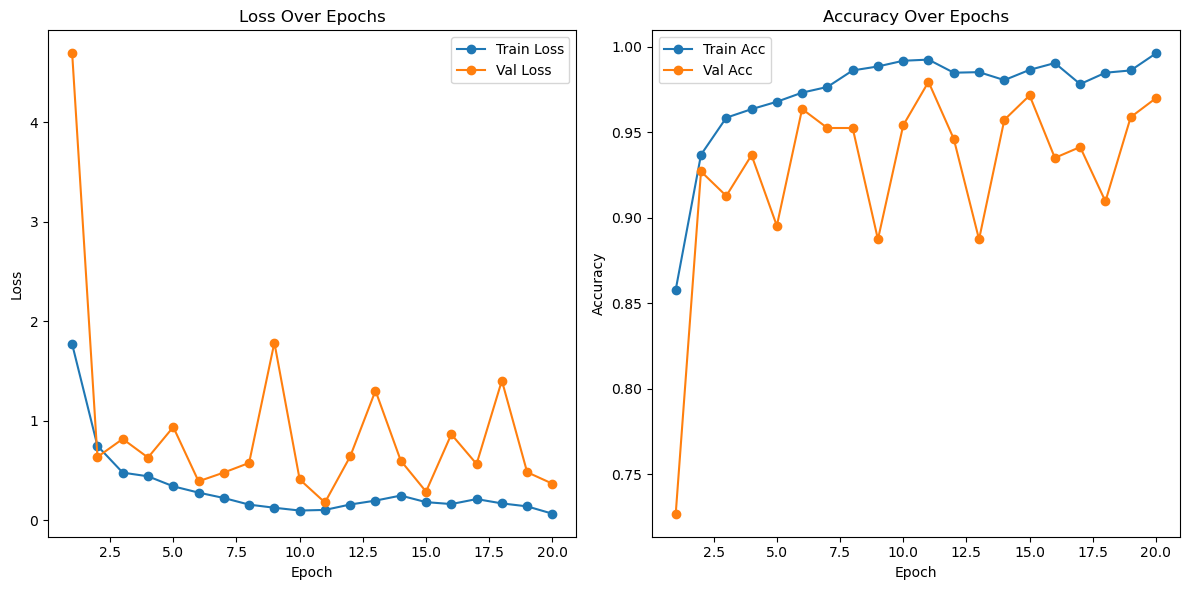

In [7]:
# Plot the train and val losses and accuracies

plot_train_val_losses(num_epochs, train_losses, train_accuracies, val_losses, val_accuracies)